In [1]:
# imports
import json
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import sklearn
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from time import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor 
from statistics import mean

In [2]:
city = 'Kolkata'
PATH = f'/media/root/data/analysis/data/Item_wise_data/{city}/'

In [3]:
# data read
df1 = pd.read_excel(PATH+f'Item_wise-details-{city}-17-23-Dec-2021.xlsx')
df2 = pd.read_excel(PATH+f'Item_wise-details-{city}-24-31-Dec-2021.xlsx')

In [4]:
# exclude non baking items
df = pd.concat([df1, df2])
df = df[pd.notna(df['Oven_Time'])]
df = df.sort_values(by =['Kitchen_Display_Time', 'Location_Code', 'Order_Number'])

In [5]:
print(df.shape)
df = df.drop(['storedesc', 'city', 'Customer_Code', 'Customer_Name', 'Actual_Order_Date', 'Order_Status_Code', 'Order_Type_Code', 'Order_Saved', 'Order_Time', 'Driver_ID', 'Driver_Shift', 'Route_Time', 'Return_Time', 'Delayed_Order', 'Order_Taker_ID','Order_Taker_Shift', 'Closed_Order_Time', 'Customer_Address_Id', 'Original_Location_Code', 'Order_Id',], axis=1)
print(df.shape)
df['Kitchen_Display_Time'] = pd.to_datetime(df['Kitchen_Display_Time'])
df['Oven_Time'] = pd.to_datetime(df['Oven_Time'])
df['prep_time'] = df['Oven_Time'] - df['Kitchen_Display_Time']
df['prep_time'] = round(df['prep_time']/np.timedelta64(1, 's')).astype(int) + 7*60
print(df.shape)
df.head()

(319080, 27)
(319080, 7)
(319080, 8)


,Location_Code,Order_Date,Order_Number,Kitchen_Display_Time,Oven_Time,Menu_Code,Item Description,prep_time
38132,DPI66010,2021-12-17,1,2021-12-17 11:01:02.263,2021-12-17 11:18:02.407,PIZ0129,_PIZ35-Pizza Mania Onion,1440
42809,DPI66010,2021-12-17,1,2021-12-17 11:01:02.263,2021-12-17 11:18:03.910,PIZ5109,PM Chicken Sausage,1442
42810,DPI66010,2021-12-17,1,2021-12-17 11:01:02.263,2021-12-17 11:18:04.330,PIZ5109,PM Chicken Sausage,1442
42811,DPI66010,2021-12-17,1,2021-12-17 11:01:02.263,2021-12-17 11:18:04.723,PIZ5109,PM Chicken Sausage,1442
42812,DPI66010,2021-12-17,1,2021-12-17 11:01:02.263,2021-12-17 11:18:05.540,PIZ5109,PM Chicken Sausage,1443


In [6]:
allMenuCodes = df['Menu_Code'].unique()
allStoreIds = df['Location_Code'].unique()

In [7]:
sampleItem=None
for index, item in df.iterrows():
    sampleItem = item
    break

In [8]:
sampleItem

Location_Code                             DPI66010
Order_Date                     2021-12-17 00:00:00
Order_Number                                     1
Kitchen_Display_Time    2021-12-17 11:01:02.263000
Oven_Time               2021-12-17 11:18:02.407000
Menu_Code                                  PIZ0129
Item Description          _PIZ35-Pizza Mania Onion
prep_time                                     1440
Name: 38132, dtype: object

In [9]:
# Feature 1: store id
def getOneHotEncodingStore(storeId, stores=allStoreIds):
    oneHotEncodingList = []
    for i in range(0, len(stores)):
        if(stores[i] == storeId):
            oneHotEncodingList.append(1)
        else:
            oneHotEncodingList.append(0)
    return oneHotEncodingList

# returns the feature store id for an order
def getStoreId(item, isOneHotEncodingRequired=False):
    if isOneHotEncodingRequired:
        return getOneHotEncodingStore(item['Location_Code'], allStoreIds)
    else:
        return [item['Location_Code']]

In [10]:
print(getStoreId(sampleItem))
print(getStoreId(sampleItem, True))

['DPI66010']
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [11]:
# Feature 2: Item Type
def getOneHotEncodingItem(item, items=allMenuCodes, clubCategoryWise=False):
    if clubCategoryWise:
        newItemsList = []
        newItemsList = [i[0:3] for i in items]
        unique_items = list(dict.fromkeys(newItemsList))
        return getOneHotEncodingItem(item[0:3], unique_items, False)
    
    oneHotEncodingList=[]
    for i in range(0, len(items)):
        if (items[i] == item):
            oneHotEncodingList.append(1)
        else:
            oneHotEncodingList.append(0)
    return oneHotEncodingList

def getItemType(item, isOneHotEncodingRequired=False, clubCategoryWise=False):
    if (not isOneHotEncodingRequired):
        if clubCategoryWise:
            return [item['Menu_Code'][0:3]]
        return [item['Menu_Code']]
    else:
        return getOneHotEncodingItem(item['Menu_Code'], allMenuCodes, clubCategoryWise)

In [12]:
print(getItemType(sampleItem))
print(getItemType(sampleItem, True))
print(getItemType(sampleItem, clubCategoryWise=True))
print(getItemType(sampleItem, True, True))

['PIZ0129']
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['PIZ']
[1, 0, 0, 0, 0, 0, 0, 0]


In [13]:
# Feature 3: TimeSlot of kitchen display time
total_slots = 24
def getTimeslot(dt, slots=total_slots):
	current = datetime(2011, 1, 1)
	t1 = current.time()
	t2 = dt.time()
	for i in range(0, slots):
		current = current + timedelta(minutes = 60*24/slots)
		if(current.time() > t2):
			return i
	return slots-1

def getOneHotEncodingTimeSlot(timeslot):
    oneHotEncodingList = []
    for i in range(0, 24):
        oneHotEncodingList.append(0)
    oneHotEncodingList[timeslot] = 1
    return oneHotEncodingList

def getTimeSlotOfKitchenDisplayTime(item, isOneHotEncodingRequired=False):
    timeslot = getTimeslot(item['Kitchen_Display_Time'], 24)
    if isOneHotEncodingRequired:
        return getOneHotEncodingTimeSlot(timeslot)
    else:
        return [timeslot]

In [14]:
def get_preparation_time(item):
    return item['prep_time']
# 	diff = item['Oven_Time'] - item['Kitchen_Display_Time']
# 	return diff.total_seconds() + 7*60

In [15]:
#DON"T RUN IT AGAIN AND AGAIN, it will take much more time
# Feature 4 : Count of all baking items of all orders received by the store in the last 20 minutes.

# Pre-preparation of data
df['pre_prep_time'] = 0

StoreWiseItems = {}
for index, item in df.iterrows():
    store = item['Location_Code']
    if store in StoreWiseItems:
        dtKitchenDisplay = item['Kitchen_Display_Time']
        lastTime = dtKitchenDisplay - timedelta(minutes=60)
        count = 0
        pt = 0
        for i in reversed(range(len(StoreWiseItems[store]))):
            if(StoreWiseItems[store][i]['Kitchen_Display_Time'] >= lastTime and StoreWiseItems[store][i]['Kitchen_Display_Time'] < dtKitchenDisplay):
                if(StoreWiseItems[store][i]['Menu_Code'] == item['Menu_Code']):
                    pt += get_preparation_time(item)
                    count+=1
            else:
                break
        if count != 0:
            df['pre_prep_time'][index] = pt/count
        else:
            df['pre_prep_time'][index] = 10*60
        StoreWiseItems[store].append(item)
    else:
        StoreWiseItems[store] = [item]
        df['pre_prep_time'][index] = 10*60

        
storeWiseCumulativeItems = {}
StoreWiseDFs = {}
for store in StoreWiseItems.keys():
    StoreWiseDFs[store] = pd.DataFrame.from_dict(StoreWiseItems[store])
    storeWiseCumulativeItems[store] = {}

# item count per slot
for store in StoreWiseItems.keys():
    for item in StoreWiseItems[store]:
        date = item['Order_Date']
        minuteSlot = getTimeslot(item['Kitchen_Display_Time'], 24*60)
        if date in storeWiseCumulativeItems[store]:
            storeWiseCumulativeItems[store][date][minuteSlot]+=1
        else:
            t = []
            for i in range(0, 24*60):
                t.append(0)
            storeWiseCumulativeItems[store][date] = t
            storeWiseCumulativeItems[store][date][minuteSlot] = 1
            
#prefix sum            
for store in storeWiseCumulativeItems.keys():
    for date in storeWiseCumulativeItems[store].keys():
        for i in range(1, 24*60):
            storeWiseCumulativeItems[store][date][i] += storeWiseCumulativeItems[store][date][i-1]
            
            
def countPastOrders(item, storeWiseCumulativeItems=storeWiseCumulativeItems, slotTime=30):
    minuteSlot = getTimeslot(item['Kitchen_Display_Time'], 24*60)
    total = storeWiseCumulativeItems[item['Location_Code']][item['Order_Date']][minuteSlot]
    prev = storeWiseCumulativeItems[item['Location_Code']][item['Order_Date']][max(minuteSlot-slotTime, 0)]
    return [(total-prev)]

/tmp/ipykernel_103677/2016951000.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pre_prep_time'][index] = 10*60
/tmp/ipykernel_103677/2016951000.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pre_prep_time'][index] = 10*60
/tmp/ipykernel_103677/2016951000.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pre_prep_time'][index] = pt/count


In [16]:
print(countPastOrders(sampleItem))
print(countPastOrders(sampleItem, slotTime=10))

d = datetime.strptime('2021-12-20 00:00:00', '%Y-%m-%d %H:%M:%S')
# storeWiseCumulativeItems[sampleItem['Location_Code']][d]

[13]
[13]


In [17]:
type(StoreWiseItems[sampleItem['Location_Code']])

list

In [18]:
# Feature 5 : Avg prep time of the same item in the same store in last 60 minutes.

def getPreviousPrepTime(item, StoreWiseItems=StoreWiseItems, clubCategoryWise=False, timeslot = 60):
    dtKitchenDisplay = item['Kitchen_Display_Time']
    lastTime = dtKitchenDisplay - timedelta(minutes=timeslot)
    
    orderedItem = item['Menu_Code']
    prepTime = []
    if clubCategoryWise:
        orderedItem = orderedItem[0:3]
    d = StoreWiseDFs[item['Location_Code']]
    tdf = d[(d['Menu_Code'].str[0:len(orderedItem)]==orderedItem) \
             & (d['Kitchen_Display_Time'] >= lastTime) & (d['Kitchen_Display_Time'] <= dtKitchenDisplay)]

    if(len(tdf)>0):
        return [tdf['prep_time'].mean()]
    else:
        return [10*60]


# def getPreviousPrepTime(item, StoreWiseItems=StoreWiseItems, clubCategoryWise=False, timeslot = 60):
#     dtKitchenDisplay = item['Kitchen_Display_Time']
#     lastTime = dtKitchenDisplay - timedelta(minutes=timeslot)
    
#     orderedItem = item['Menu_Code']
#     prepTime = []
#     if clubCategoryWise:
#         orderedItem = orderedItem[0:3]
#     tdf = df[(df['Location_Code']==item['Location_Code']) & (df['Menu_Code'].str[0:len(orderedItem)]==orderedItem) \
#              & (df['Kitchen_Display_Time'] >= lastTime) & (df['Kitchen_Display_Time'] <= dtKitchenDisplay)]

#     if(len(tdf)>0):
#         return [tdf['prep_time'].mean()]
#     else:
#         return [10*60]

    
# Feature 6 : Length of the queue in the store at that time
def lengthQueue(item):
    dtKitchenDisplay = item['Kitchen_Display_Time']
    d = StoreWiseDFs[item['Location_Code']]
    tdf = d[(d['Oven_Time'] >= dtKitchenDisplay) & (d['Kitchen_Display_Time'] <= dtKitchenDisplay)]
    
#     prepTime = []
#     tdf = df[(df['Location_Code']==item['Location_Code']) & \
#              (df['Oven_Time'] >= dtKitchenDisplay) & (df['Kitchen_Display_Time'] <= dtKitchenDisplay)]
    return len(tdf.index)
#     for order in StoreWiseItems[item['Location_Code']]:
#         if(order['Kitchen_Display_Time'] >= lastTime and order['Kitchen_Display_Time'] <= dtKitchenDisplay):
#             if (order['Menu_Code'][0:len(orderedItem)] == orderedItem):
#                 prepTime.append(get_preparation_time(order))
#     if(len(prepTime) > 0):
#         return [mean(prepTime)]
#     else:
#         return [10*60] # POINT OF DISCUSSION, For now taking 10 minutes

In [19]:
getPreviousPrepTime(sampleItem, StoreWiseItems, False, 60)
lengthQueue(sampleItem)

13

In [20]:
item = sampleItem
orderedItem = item['Menu_Code']
orderedItem = orderedItem[0:3]
dtKitchenDisplay = item['Kitchen_Display_Time']
lastTime = dtKitchenDisplay - timedelta(minutes=60)
tdf = df[(df['Location_Code']==item['Location_Code']) & (df['Menu_Code'].str[0:len(orderedItem)]==orderedItem) \
         & (df['Kitchen_Display_Time'] >= lastTime) & (df['Kitchen_Display_Time'] <= dtKitchenDisplay)]
print(item, len(tdf)) 
if(len(tdf)>0):
    print([round(tdf['prep_time'].mean())])
tdf

Location_Code                             DPI66010
Order_Date                     2021-12-17 00:00:00
Order_Number                                     1
Kitchen_Display_Time    2021-12-17 11:01:02.263000
Oven_Time               2021-12-17 11:18:02.407000
Menu_Code                                  PIZ0129
Item Description          _PIZ35-Pizza Mania Onion
prep_time                                     1440
Name: 38132, dtype: object 13
[1458]


,Location_Code,Order_Date,Order_Number,Kitchen_Display_Time,Oven_Time,Menu_Code,Item Description,prep_time,pre_prep_time
38132,DPI66010,2021-12-17,1,2021-12-17 11:01:02.263,2021-12-17 11:18:02.407,PIZ0129,_PIZ35-Pizza Mania Onion,1440,600
42809,DPI66010,2021-12-17,1,2021-12-17 11:01:02.263,2021-12-17 11:18:03.910,PIZ5109,PM Chicken Sausage,1442,600
42810,DPI66010,2021-12-17,1,2021-12-17 11:01:02.263,2021-12-17 11:18:04.330,PIZ5109,PM Chicken Sausage,1442,600
42811,DPI66010,2021-12-17,1,2021-12-17 11:01:02.263,2021-12-17 11:18:04.723,PIZ5109,PM Chicken Sausage,1442,600
42812,DPI66010,2021-12-17,1,2021-12-17 11:01:02.263,2021-12-17 11:18:05.540,PIZ5109,PM Chicken Sausage,1443,600
45522,DPI66010,2021-12-17,1,2021-12-17 11:01:02.263,2021-12-17 11:18:05.847,PIZ5109,PM Chicken Sausage,1444,600
45523,DPI66010,2021-12-17,1,2021-12-17 11:01:02.263,2021-12-17 11:18:06.503,PIZ5109,PM Chicken Sausage,1444,600
45524,DPI66010,2021-12-17,1,2021-12-17 11:01:02.263,2021-12-17 11:18:07.000,PIZ5109,PM Chicken Sausage,1445,1960
45525,DPI66010,2021-12-17,1,2021-12-17 11:01:02.263,2021-12-17 11:18:07.480,PIZ5109,PM Chicken Sausage,1445,994
45526,DPI66010,2021-12-17,1,2021-12-17 11:01:02.263,2021-12-17 11:18:08.057,PIZ5109,PM Chicken Sausage,1446,600


In [21]:
# global variables

isThresholdForPreparationTime = False
thresholdForPreparationTime = 30 # minutes for preparation time (threshold)

clubItemsCategoryWise = False

splitMethod = 'random'
slotTimeForPastOrders = 20 # minutes

model = 'RF'
isOneHotEncodingRequired = True
isNormalizationRequired = True

In [22]:
sampleItem

Location_Code                             DPI66010
Order_Date                     2021-12-17 00:00:00
Order_Number                                     1
Kitchen_Display_Time    2021-12-17 11:01:02.263000
Oven_Time               2021-12-17 11:18:02.407000
Menu_Code                                  PIZ0129
Item Description          _PIZ35-Pizza Mania Onion
prep_time                                     1440
Name: 38132, dtype: object

In [24]:
X_train, X_test, y_train, y_test = [], [], [], []
X = []
y = []
import time
t1 = t2 = t3 = t4 = t5 = t6 = t7 = 0
i = 0
for index, item in df.iterrows():
    i+=1
    if(i%1000==0): print(t1, t2, t3, t4, t5, t6, t7)
    if(isThresholdForPreparationTime and (get_preparation_time(item) > thresholdForPreparationTime*60)): #removing inputs 
        continue
        
    features = []
    t = time.time()
    features = features + getStoreId(item, isOneHotEncodingRequired)
    t1 += time.time() - t
    print(len(features), features)
    
    t = time.time()
    features = features + getItemType(item, isOneHotEncodingRequired=isOneHotEncodingRequired, clubCategoryWise=clubItemsCategoryWise)
    t2 += time.time() - t
    print(len(features), features)

    t = time.time()    
    features = features + getTimeSlotOfKitchenDisplayTime(item, isOneHotEncodingRequired=isOneHotEncodingRequired)
    t3 += time.time() - t
    print(len(features), features)

    t = time.time()
    features = features + countPastOrders(item, storeWiseCumulativeItems, slotTimeForPastOrders) 
    t4 += time.time() - t
    print(len(features), features)

    t = time.time()
    features = features + getPreviousPrepTime(item, clubCategoryWise=clubItemsCategoryWise, timeslot = 60)  
    t5 += time.time() - t
    print(len(features), features)

    t = time.time()        
    features = features + [lengthQueue(item)]
    t6 += time.time() - t
    print(len(features), features)

    t = time.time()
    X.append(features)
    y.append(get_preparation_time(item))
    t7 += time.time() - t
    break

#     if((order['ORDER_DATE'] >='2021-12-20' and order['ORDER_DATE'] <= '2021-12-24') or (order['ORDER_DATE'] >='2021-12-27' and order['ORDER_DATE'] <= '2021-12-29')):
#         X_train.append(features)
#         y_train.append(420+round(get_preparation_time(order)))
#     elif(order['ORDER_DATE'] =='2021-12-30'):
#         X_test.append(features)
#         y_test.append(420+round(get_preparation_time(order)))
print(t1, t2, t3, t4, t5, t6, t7)

52 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
145 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
169 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [28]:
print(len(allStoreIds))
print(len(allMenuCodes))
print(total_slots, 24)


52
93
24 24


In [27]:
X_train, X_test, y_train, y_test = [], [], [], []
X = []
y = []
import time
t1 = t2 = t3 = t4 = t5 = t6 = t7 = 0
i = 0
for index, item in df.iterrows():
    i+=1
    if(i%1000==0): print(t1, t2, t3, t4, t5, t6, t7)
    if(isThresholdForPreparationTime and (get_preparation_time(item) > thresholdForPreparationTime*60)): #removing inputs 
        continue
        
    features = []
    t = time.time()
    features = features + getStoreId(item, isOneHotEncodingRequired)
    t1 += time.time() - t
    
    t = time.time()
    features = features + getItemType(item, isOneHotEncodingRequired=isOneHotEncodingRequired, clubCategoryWise=clubItemsCategoryWise)
    t2 += time.time() - t

    t = time.time()    
    features = features + getTimeSlotOfKitchenDisplayTime(item, isOneHotEncodingRequired=isOneHotEncodingRequired)
    t3 += time.time() - t

    t = time.time()
    features = features + countPastOrders(item, storeWiseCumulativeItems, slotTimeForPastOrders) 
    t4 += time.time() - t

    t = time.time()
    features = features + getPreviousPrepTime(item, clubCategoryWise=clubItemsCategoryWise, timeslot = 60)  
    t5 += time.time() - t

    t = time.time()        
    features = features + [lengthQueue(item)]
    t6 += time.time() - t
    
    t = time.time()
    X.append(features)
    y.append(get_preparation_time(item))
    t7 += time.time() - t

#     if((order['ORDER_DATE'] >='2021-12-20' and order['ORDER_DATE'] <= '2021-12-24') or (order['ORDER_DATE'] >='2021-12-27' and order['ORDER_DATE'] <= '2021-12-29')):
#         X_train.append(features)
#         y_train.append(420+round(get_preparation_time(order)))
#     elif(order['ORDER_DATE'] =='2021-12-30'):
#         X_test.append(features)
#         y_test.append(420+round(get_preparation_time(order)))
print(t1, t2, t3, t4, t5, t6, t7)

0.05244946479797363 0.05461597442626953 0.061420440673828125 1.145925521850586 5.015494346618652 1.4338629245758057 0.0292203426361084
0.10144615173339844 0.10643935203552246 0.12420082092285156 2.389873743057251 9.91579794883728 2.86791729927063 0.05788612365722656
0.1503918170928955 0.15810918807983398 0.18761038780212402 3.711069107055664 14.783612489700317 4.287933588027954 0.08632254600524902
0.19904756546020508 0.20922064781188965 0.2522125244140625 5.122316122055054 19.565389156341553 5.7004618644714355 0.11414766311645508
0.24909234046936035 0.2612721920013428 0.319333553314209 6.622399568557739 24.480414152145386 7.141343832015991 0.14287662506103516
0.2992079257965088 0.31346583366394043 0.3877882957458496 8.150545835494995 29.328891277313232 8.581228733062744 0.17179298400878906
0.3497166633605957 0.36590099334716797 0.4570930004119873 9.744909048080444 34.21784329414368 10.039466619491577 0.20087003707885742
0.3994147777557373 0.41752099990844727 0.5266804695129395 11.35193

3.2952330112457275 3.407499313354492 4.51931357383728 103.84864568710327 318.9193949699402 92.64584612846375 1.885000467300415
3.3434410095214844 3.4580562114715576 4.585775136947632 105.33879494667053 323.6831851005554 94.0554850101471 1.9135923385620117
3.3922762870788574 3.507960796356201 4.651739597320557 106.87297224998474 328.480938911438 95.4678282737732 1.9421675205230713
3.4432785511016846 3.561075448989868 4.723073720932007 108.50687575340271 333.3536307811737 96.91135621070862 1.971435546875
3.493802547454834 3.6133596897125244 4.793494462966919 110.16357755661011 338.12363505363464 98.3028998374939 1.9998185634613037
3.545090913772583 3.6659631729125977 4.864940881729126 111.8401460647583 343.0073926448822 99.68921661376953 2.0285558700561523
3.5957603454589844 3.7190418243408203 4.936419725418091 113.55307865142822 347.8593969345093 101.0981776714325 2.0578792095184326
3.6487953662872314 3.7736799716949463 5.01270866394043 115.36433482170105 352.84419417381287 102.52645277

6.489934921264648 6.721131324768066 8.953305721282959 205.93183827400208 631.9015827178955 183.55668830871582 3.7610373497009277
6.54105019569397 6.773671627044678 9.018784284591675 207.27820539474487 636.8875875473022 185.01490950584412 3.790489435195923
6.58824610710144 6.82265830039978 9.08171534538269 208.63123035430908 641.6898951530457 186.4078733921051 3.8244168758392334
6.6365966796875 6.873437881469727 9.147316455841064 210.07318687438965 646.584418296814 187.79974269866943 3.8527190685272217
6.685895681381226 6.924668550491333 9.21524167060852 211.60273003578186 651.5488710403442 189.21544289588928 3.8811233043670654
6.7358012199401855 6.976402521133423 9.28409743309021 213.15674352645874 656.4811973571777 190.64168214797974 3.9102399349212646
6.787110328674316 7.028504133224487 9.354294776916504 214.76979517936707 661.4296779632568 192.10252833366394 3.940009593963623
6.837592363357544 7.080261468887329 9.424211502075195 216.39710021018982 666.3790295124054 193.5519487857818

9.76822829246521 10.089584350585938 13.50715184211731 311.65577459335327 951.5320014953613 276.6186740398407 5.6883385181427
9.819231033325195 10.142439365386963 13.578574657440186 313.34097170829773 956.4658336639404 278.0562882423401 5.717677593231201
9.868803262710571 10.193326234817505 13.648635864257812 315.0282504558563 961.2821531295776 279.4764850139618 5.746605157852173
9.92288875579834 10.248354196548462 13.724157810211182 316.81047224998474 966.3860065937042 280.9619197845459 5.777291536331177
9.973499059677124 10.300086736679077 13.796966552734375 318.54607009887695 971.2906453609467 282.38338899612427 5.806391716003418
10.023361921310425 10.351141691207886 13.868093967437744 320.2964220046997 976.1655313968658 283.8088729381561 5.835301876068115
10.076436758041382 10.40566086769104 13.943292140960693 322.1133658885956 981.1388230323792 285.25524735450745 5.865152835845947
10.127743005752563 10.458125352859497 14.017959833145142 323.93003010749817 986.0716981887817 286.6916

13.01798677444458 13.422460317611694 18.056413412094116 417.6243824958801 1266.8094651699066 368.4964575767517 7.601860523223877
13.071213722229004 13.476897716522217 18.12523055076599 419.0523250102997 1271.819017648697 369.9476969242096 7.632172346115112
13.12038516998291 13.527437448501587 18.191463947296143 420.50263476371765 1276.5782685279846 371.3300862312317 7.660413026809692
13.166537046432495 13.575217723846436 18.25574231147766 421.99642610549927 1281.3023552894592 372.68628907203674 7.687536716461182
13.215972423553467 13.626111030578613 18.32385778427124 423.5470848083496 1286.116562128067 374.0971620082855 7.716327428817749
13.265661478042603 13.67674994468689 18.392600536346436 425.14217495918274 1290.9172475337982 375.49402618408203 7.7446722984313965
13.314646482467651 13.726866006851196 18.46155333518982 426.7909197807312 1295.6899704933167 376.88333535194397 7.77313494682312
13.363316774368286 13.776983737945557 18.5316424369812 428.4726529121399 1300.4434821605682 3

In [29]:
len(X), len(y), len(X[0])

(319080, 319080, 172)

In [37]:
bakeup_X = X
bakeup_y = y

In [38]:
n = len(allStoreIds)
store_wise_X = [[] for _ in range(n)]
store_wise_y = [[] for _ in range(n)]

for j in range(n):
    for i in range(len(X)):
        if X[i][j] > 0:
            store_wise_X[j].append(X[i][n:])
            store_wise_y[j].append(y[i])

# store_wise_X = [[x for x in X] for j in range(n)]
# store_wise_X = [x for j in range(n) for _,y in zip(X,y) if x[j]>0]

In [39]:
l = []

for i in range(n):
    X = store_wise_X[i]
    y = store_wise_y[i]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)
    
#     print("Random Forest Model", i, len(y_train), len(y_test))
    regressor = RandomForestRegressor()
    if(isNormalizationRequired):
        scaler = StandardScaler()
        scaler.fit(X_train)

        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
    
    regressor.fit(X_train, y_train)
    predictions = regressor.predict(X_train)
    a = getRMSE(y_train, predictions)
#     print("RMSE score on train set: ", a)
    
    predictions = regressor.predict(X_test)
    b = getRMSE(y_test, predictions)
#     print("RMSE score on test set: ", b)
    l.append((a, b, len(y_train), len(y_test)))
l

[(69.74398235134973, 110.73278958157061, 5624, 1407),
 (16.738956301746523, 49.32246633110388, 5418, 1355),
 (20.941754553757004, 55.37988339949047, 3900, 975),
 (12.244685715507316, 33.465189509275554, 7317, 1830),
 (24.467417227594503, 59.11416492174018, 7378, 1845),
 (16.887313639164148, 43.10657369954303, 6587, 1647),
 (13.515021034227676, 33.47246951146438, 4156, 1039),
 (23.77732100503141, 72.4253925848281, 7211, 1803),
 (19.286207885640458, 45.76296670557789, 5544, 1387),
 (17.83889285373208, 42.63308426676605, 6660, 1665),
 (17.778161821915013, 48.302599405662285, 4647, 1162),
 (14.040543395987301, 35.90283616130062, 4374, 1094),
 (13.942417268207851, 35.454505722680864, 4564, 1141),
 (14.392077412103925, 38.54280595325719, 6808, 1702),
 (12.269205008270605, 34.767052723558145, 4554, 1139),
 (12.121267980367186, 31.738060997397362, 1852, 464),
 (13.649929213959265, 36.74645170966107, 3004, 752),
 (25.518357864360535, 71.65103986158648, 5135, 1284),
 (25.61608632287833, 59.67363

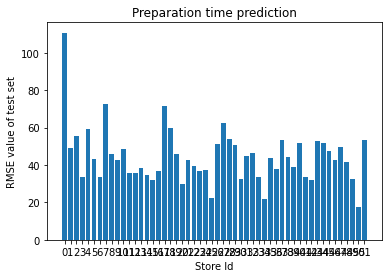

[110.73278958157061,
 49.32246633110388,
 55.37988339949047,
 33.465189509275554,
 59.11416492174018,
 43.10657369954303,
 33.47246951146438,
 72.4253925848281,
 45.76296670557789,
 42.63308426676605,
 48.302599405662285,
 35.90283616130062,
 35.454505722680864,
 38.54280595325719,
 34.767052723558145,
 31.738060997397362,
 36.74645170966107,
 71.65103986158648,
 59.67363884805792,
 45.93041198512772,
 29.756997422734266,
 42.62418049051106,
 39.31798143555204,
 36.76740421345306,
 37.41720741610458,
 22.365941358295157,
 51.084478098561775,
 62.36693863372644,
 53.886169015598,
 50.7841102357929,
 32.55067157395881,
 45.012988685034514,
 46.58974031583464,
 33.45213591062193,
 21.806428451451232,
 43.748613200587464,
 38.037165445368274,
 53.29321663147165,
 44.540710687406026,
 39.129142631517276,
 51.560226266215935,
 33.82543865871016,
 31.984871679588,
 52.78730247929248,
 51.800579368105936,
 47.609827843164254,
 42.830091371656174,
 49.361575631614116,
 41.587062003959346,
 32.4

In [41]:
X_t = [i for i in range(len(allStoreIds))]
Y_t = [x[1] for x in l]
Y_t, X_t
plt.bar(X_t, Y_t)
plt.xticks(X_t)
plt.xlabel("Store Id")
plt.ylabel("RMSE value of test set")
plt.title("Preparation time prediction")
plt.show()
Y_t

In [49]:
# l = [len(x) for x in store_wise_y]
# sum(l)
# len(store_wise_X[0][0]), n
# Y_t = l[:][1]
# Y_t
X_t = [i for i in range(11)]
Y_t = [x[1] for x in l]
Y_t, X_t

([46.474329866513,
  30.378945504039407,
  51.76135265403258,
  38.465051022292506,
  32.30800862059353,
  17.65975373869952,
  41.47104984259385,
  54.02779294717718,
  26.479798936643498,
  41.46850661965206,
  29.7014803993898],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [42]:
l2 = [(a**2)*b for _,a,_,b in l]
l3 = [b for _,_,_,b in l]
combine_rmse = (sum(l2)/sum(l3))**(1/2)
combine_rmse

48.22294420867523

In [30]:
if splitMethod == 'random':
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [31]:
def getRMSE(actual, predictions):
    mse = sklearn.metrics.mean_squared_error(actual, predictions)
    return math.sqrt(mse)

In [32]:
# random forest
if (model=='RF'):
    print("Random Forest Model")
    regressor = RandomForestRegressor()
    if(isNormalizationRequired):
        scaler = StandardScaler()
        scaler.fit(X_train)

        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
    
    regressor.fit(X_train, y_train)
    predictions = regressor.predict(X_train)
    print("RMSE score on train set: ", getRMSE(y_train, predictions))
        
    predictions = regressor.predict(X_test)
    print("RMSE score on test set: ", getRMSE(y_test, predictions))
    

Random Forest Model
RMSE score on train set:  22.19547314114051
RMSE score on test set:  51.22502917357771


In [33]:
predictions = regressor.predict(X_train)
print("RMSE score on train set: ", getRMSE(y_train, predictions))

predictions = regressor.predict(X_test)
print("RMSE score on test set: ", getRMSE(y_test, predictions))

RMSE score on train set:  22.19547314114051
RMSE score on test set:  51.22502917357771


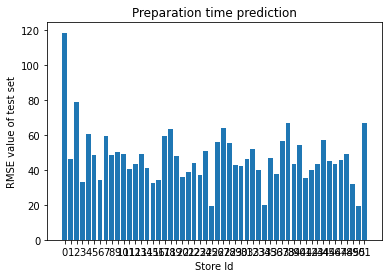

In [34]:
X_t = []
Y_t = []
for j in range(0, len(allStoreIds)):
    xx = []
    yy = []
    for i in range(0, len(X_test)):
        if(X_test[i][j] > 0):
            xx.append(X_test[i])
            yy.append(y_test[i])
    X_t.append(j)
    Y_t.append(getRMSE(yy, regressor.predict(xx)))
    
plt.bar(X_t, Y_t)
plt.xticks(X_t)
plt.xlabel("Store Id")
plt.ylabel("RMSE value of test set")
plt.title("Preparation time prediction")
plt.show()

In [35]:
Y_t_all = Y_t
Y_t_all

[118.46762915044431,
 46.19214819316697,
 78.84432832325724,
 33.148221209727005,
 60.301924988108524,
 48.615090407280086,
 34.03093474167357,
 59.34757224485053,
 48.664450262389366,
 50.25310172606236,
 48.98357861203935,
 40.525496709546886,
 43.335434189959194,
 49.219792388384555,
 40.85527237512303,
 32.29103524166308,
 34.437496172634745,
 59.579805977976385,
 63.671188315255904,
 48.2129598164105,
 36.09697185113681,
 38.60470625511067,
 43.782416261273916,
 37.22711862749954,
 50.99678360383393,
 19.476519883954346,
 55.930706645867026,
 64.22696252987792,
 55.34549010676449,
 42.86917768711083,
 42.2009622303691,
 46.285075410182515,
 52.1492828828175,
 39.75615609594073,
 19.98575780828075,
 46.74552959859113,
 37.853908645238725,
 56.29227956100993,
 66.55349208403143,
 43.08851480876491,
 54.21395311188494,
 35.25538933835721,
 39.9118331637077,
 43.370350828934534,
 57.35408329558492,
 45.33737635791099,
 43.10834813720752,
 45.8468274999213,
 48.97622182161247,
 32.0385

In [47]:
X_Axis = [i for i in range(10, 24)]
RMSETimeSlotWise = {}
total_items = len(allMenuCodes)+len(allStoreIds)
for x in X_Axis:
    x1 = []
    y1 = []
    for i in range(0, len(X_test)):
        if(X_test[i][total_items+x] > 0):
            x1.append(X_test[i])
            y1.append(y_test[i])
    RMSETimeSlotWise[x] = getRMSE(y1, regressor.predict(x1))
    
X_axis = list(RMSETimeSlotWise.keys())
Y_axis = list(RMSETimeSlotWise.values())

plt.bar(X_axis, Y_axis)
plt.xticks(X_axis, rotation='vertical')
plt.xlabel("Time slot")
plt.ylabel("RMSE value of test set")
plt.title("Preparation time prediction over different time slots")
plt.show()

IndexError: index 155 is out of bounds for axis 0 with size 120

In [44]:
y = []
for i in X_t:
    y.append((Y_t[i], Y_t_all[i]))
    print(i, Y_t[i], Y_t_all[i])
#     if Y_t_all[x][y] = 4
    
# y

0 110.73278958157061 118.46762915044431
1 49.32246633110388 46.19214819316697
2 55.37988339949047 78.84432832325724
3 33.465189509275554 33.148221209727005
4 59.11416492174018 60.301924988108524
5 43.10657369954303 48.615090407280086
6 33.47246951146438 34.03093474167357
7 72.4253925848281 59.34757224485053
8 45.76296670557789 48.664450262389366
9 42.63308426676605 50.25310172606236
10 48.302599405662285 48.98357861203935
11 35.90283616130062 40.525496709546886
12 35.454505722680864 43.335434189959194
13 38.54280595325719 49.219792388384555
14 34.767052723558145 40.85527237512303
15 31.738060997397362 32.29103524166308
16 36.74645170966107 34.437496172634745
17 71.65103986158648 59.579805977976385
18 59.67363884805792 63.671188315255904
19 45.93041198512772 48.2129598164105
20 29.756997422734266 36.09697185113681
21 42.62418049051106 38.60470625511067
22 39.31798143555204 43.782416261273916
23 36.76740421345306 37.22711862749954
24 37.41720741610458 50.99678360383393
25 22.365941358295

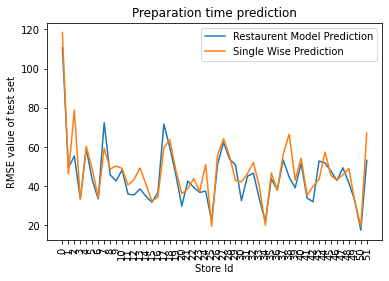

In [48]:
# plt.plot(X_t, Y_t, label = 'Single Model Prediction')
# plt.plot(X_t, Y_t_all, label = 'Restaurent Wise Prediction')

plt.plot(X_t, y)
plt.legend(['Restaurent Model Prediction', 'Single Wise Prediction'])

plt.xticks(X_t, rotation='vertical')
plt.xlabel("Store Id")
plt.ylabel("RMSE value of test set")
plt.title("Preparation time prediction")
plt.show()

In [89]:
# #activation: relu, logistic
# def ModelResults(X_train, X_test, y_train, y_test, model, isNormalizationRequired=True):
    
#     if(isNormalizationRequired):
#         scaler = StandardScaler()
#         scaler.fit(X_train)

#         X_train = scaler.transform(X_train)
#         X_test = scaler.transform(X_test)
        
#     if(model=='NN'):
#         hidden_layer_sizes=(80, 30, 10)
#         activation='relu'
#         print("Neural Network model")
#         print("Hidden layers: ", hidden_layer_sizes)
#         print("Activation function: ", activation)
#         mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, max_iter=1000, verbose=True, learning_rate='constant', learning_rate_init=0.01)
#         mlp.fit(X_train, y_train)
#         print(mlp.best_loss_)
        
#         predictions = mlp.predict(X_train)
#         print("RMSE score on validation set: ", getRMSE(y_train, predictions))
        
#         predictions = mlp.predict(X_test)
#         print("RMSE score on test set: ", getRMSE(y_test, predictions))
        
#     elif(model=='RF'):
#         print("Random Forest Model")
#         regressor = RandomForestRegressor()
#         regressor.fit(X_train, y_train)
        
#         predictions = regressor.predict(X_train)
#         print("RMSE score on validation set: ", getRMSE(y_train, predictions))
        
#         predictions = regressor.predict(X_test)
#         print("RMSE score on test set: ", getRMSE(y_test, predictions))
#     else:
#         print("Model not implemented yet")

In [86]:
# mlp.predict_log_proba(X)

array([[ -9.68770891,  -7.18229529,  -7.05802898, ..., -10.05756664,
        -11.47823238,  -9.53518635],
       [ -9.68770891,  -7.18229529,  -7.05802898, ..., -10.05756664,
        -11.47823238,  -9.53518635],
       [ -9.68770891,  -7.18229529,  -7.05802898, ..., -10.05756664,
        -11.47823238,  -9.53518635],
       ...,
       [ -9.68770891,  -7.18229529,  -7.05802898, ..., -10.05756664,
        -11.47823238,  -9.53518635],
       [ -9.68770891,  -7.18229529,  -7.05802898, ..., -10.05756664,
        -11.47823238,  -9.53518635],
       [ -9.68770891,  -7.18229529,  -7.05802898, ..., -10.05756664,
        -11.47823238,  -9.53518635]])

In [ ]:

# scaler = StandardScaler()
# scaler.fit(X_train)

# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

# regressor = RandomForestRegressor()
# regressor.fit(X_train, y_train)
# predictions = regressor.predict(X_train)

In [39]:
for i in range(n):
    X = store_wise_X[i]
    y = store_wise_y[i]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)
    
    print("Random Forest Model")
    regressor = RandomForestRegressor()
    if(isNormalizationRequired):
        scaler = StandardScaler()
        scaler.fit(X_train)

        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
    
    regressor.fit(X_train, y_train)
    predictions = regressor.predict(X_train)
    print("RMSE score on train set: ", getRMSE(y_train, predictions))
        
    predictions = regressor.predict(X_test)
    print("RMSE score on test set: ", getRMSE(y_test, predictions))
    

Random Forest Model
RMSE score on train set:  18.25602531368394
RMSE score on test set:  45.815872729249435
Random Forest Model
RMSE score on train set:  11.559987090939433
RMSE score on test set:  30.044338900434187
Random Forest Model
RMSE score on train set:  19.8160462425246
RMSE score on test set:  51.44029530615877
Random Forest Model
RMSE score on train set:  15.56732234897142
RMSE score on test set:  38.72006453737753
Random Forest Model
RMSE score on train set:  13.430966752860824
RMSE score on test set:  32.58723421931361
Random Forest Model
RMSE score on train set:  6.599369874774
RMSE score on test set:  17.39437297020862
Random Forest Model
RMSE score on train set:  16.52015385356523
RMSE score on test set:  41.19153062656546
Random Forest Model
RMSE score on train set:  18.478996784796827
RMSE score on test set:  54.17347072479103
Random Forest Model
RMSE score on train set:  9.99238771234968
RMSE score on test set:  26.468487048872355
Random Forest Model
RMSE score on tr

In [ ]:
# mse = sklearn.metrics.mean_squared_error(y_train, predictions)  
# rmse = math.sqrt(mse)  
# rmse

# Tasks:
## 1. find slot wise RMSE, for prep. time: 8-12 min, for 12-16 min, 16-20 min, 20 min+
### 2. relative RMSE, RMSE w.r.t to Preparation time